In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed.knee_locator import KneeLocator

# HOW CAN ADULTS SUFFERING FROM DEPRESSION BE CLUSTERED?
Anne L&ouml;sch

<img src="ethan-sykes-TdM_fhzmWog-unsplash.jpg" width="50%" />
Photo by <a href="https://unsplash.com/@e_sykes?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ethan Sykes</a> on <a href="https://unsplash.com/s/photos/depressed?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Table of Contents

* [Introduction](#introduction)
* [Research Question](#hypothesis)
* [Data](#data)
* [Methods](#methods)
* [Results](#results)
* [Discussion and Recommendations](#discussion)
* [References](#references)
* [Appendix](#appendix)

<a class="anchor" id="introduction"></a> 
# Introduction

At least 17 million adults in the US suffer from depression each year.<sup>[1](#references)</sup>  And, according to the NCBI article, <u>Depression: How effective are antidepressants?</u><sup>[2](#references)</sup>, only 40 to 60 percent of those with severe depression who take antidepressants notice an improvement in their symptoms.  In this project I would like to explore how adults suffering from depression can be clustered.  If a clear seperation of clusters can be found, tailored treatments can be created to better help those sufferening from depression.  This is a topic of personal interest as my husband suffers from chronic depression.

<a class="anchor" id="hypothesis"></a> 
# Research Question

How can adults suffering from depression be clustered?

<a class="anchor" id="data"></a> 
# Data



In order to answer this question, I am using data from the 2019 National Health Interview Survey, Sample Adult Interview.<sup>[3](#references)</sup> The National Health Intervey Survey is a yearly survey meant to 'monitor the health of the United States population.'<sup>[4](#references)</sup> It is a survey conducted in person throughout the year each year.  Populations not included in the survey: individuals with no fixed address, military personnel on active duty, people in long term care facilities, and US citizens living outside the US.  Due to this and the fact it is an optional survey, results are not completely representative of the entire US population.  

The 2019 survey comes in two forms: an adult interview and a child interview.  For the project I chose to use data from the adult interview.

Topics covered in the survey include but is not limited to: demographic data, chronic illnesses, mental health, health insurance coverage, substance use.

To run this notebook, please download the dataset and save it to a data folder.
https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NHIS/2019/adult19csv.zip

In [2]:
df = pd.read_csv('data/adult19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


The dataset consists of 31,996 observations and 534 features.  The features I plan to use are listed below.  After going through the entire codebook I chose to use only questions related to depression, demographics, chronic conditions, and substance abuse as I felt all might impact depression the most and have the fewest missing values.

In [3]:
variables_df = pd.read_csv('vars.csv')
variables_df

,Variable,Question/Description,Category
0,DEPEV_A,Ever had depression,depression
1,DEPFREQ_A,How often depressed,depression
2,DEPMED_A,Take medication for depression,depression
3,DEPLEVEL_A,Level of how depressed,depression
4,PHQ81_A,How often little interest in things past 2 weeks,depression
5,PHQ82_A,How often feeling down past 2 weeks,depression
6,PHQ83_A,How often trouble with sleeping past 2 weeks,depression
7,PHQ84_A,How often feeling tired past 2 weeks,depression
8,PHQ85_A,How often undereating or overeating past 2 weeks,depression
9,PHQ86_A,How often feeling bad about self past 2 weeks,depression


For the project, I decided to choose only the observations in which the person feels depression at least on a weekly basis.  According the the American Psychiatric Association, symptoms must last at least two weeks for a diagnosis of depression.<sup>[5](#references)</sup>  This is why I chose only those that feel depression on a weekly basis.

In [4]:
df_depressed = df[variables_df.Variable][df.DEPFREQ_A <= 2].copy()

In [5]:
df_depressed.head()

,DEPEV_A,DEPFREQ_A,DEPMED_A,DEPLEVEL_A,PHQ81_A,PHQ82_A,PHQ83_A,PHQ84_A,PHQ85_A,PHQ86_A,...,HISP_A,OPD12M_A,SMKNOW_A,ECIGNOW_A,HYPEV_A,CHLEV_A,ASEV_A,CANEV_A,DIBEV_A,COPDEV_A
4,1,1,1,3.0,4,3,2,3,2,2,...,2,2.0,1.0,NaN,1,1,1,2,1,1
28,2,2,2,3.0,1,3,3,1,2,3,...,2,NaN,1.0,3.0,2,2,2,2,2,2
37,1,1,1,3.0,1,3,4,2,1,2,...,2,2.0,1.0,NaN,1,2,2,2,2,2
41,2,2,2,3.0,2,3,4,4,4,4,...,2,2.0,NaN,NaN,2,2,2,2,2,2
48,1,1,2,1.0,1,2,1,1,2,1,...,1,2.0,3.0,1.0,1,1,1,1,2,2


## Checking for null values

In [6]:
df_depressed.isnull().sum()

DEPEV_A            0
DEPFREQ_A          0
DEPMED_A           0
DEPLEVEL_A         0
PHQ81_A            0
PHQ82_A            0
PHQ83_A            0
PHQ84_A            0
PHQ85_A            0
PHQ86_A            0
PHQ87_A            0
PHQ88_A            0
AGEP_A             0
SEX_A              0
MARITAL_A          0
FAMINCTC_A         0
EDUC_A             0
EMPWRKLSWK_A       0
RACEALLP_A         0
HISP_A             0
OPD12M_A         452
SMKNOW_A        1481
ECIGNOW_A       2310
HYPEV_A            0
CHLEV_A            0
ASEV_A             0
CANEV_A            0
DIBEV_A            0
COPDEV_A           0
dtype: int64

Since more than a third of the observations have missing values for variables SMKNOW_A and ECIGNOW_A, I am going to drop the variables having to do with substance use.

In [7]:
df_depressed.drop(['OPD12M_A','SMKNOW_A','ECIGNOW_A'],axis=1,inplace=True)

In the methods section below, I mention I split the dataset into three subsets: one containing the variables related to depression, one containing the demographic variables, and one pertaining to chronic conditions.

In [8]:
depressed_vars = variables_df[variables_df["Category"]=="depression"]["Variable"]
df_depressed_core = df_depressed[depressed_vars].copy()
demo_vars = variables_df[variables_df["Category"]=="demographics"]["Variable"]
df_demo = df_depressed[demo_vars].copy()
cc_vars = variables_df[variables_df["Category"]=="chronic_conditions"]["Variable"]
df_cc = df_depressed[cc_vars].copy()

For visualizations, numerical values will be replaced with their labels as found in the codebook.

In [9]:
yes_no_labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
freq_labels = {1:'Daily',2:'Weekly'}
lvl_labels = {1: 'A little', 2: 'A lot', 3 : 'Somewhere in between',7:'Refused',8:'Not ascertained',9:"Don't know"}
phq_labels = {1:'Not at all',2:'Several days',3:'More than half the days',4:'Nearly every day',
              7:'Refused',8:'Not ascertained',9:"Don't know"}
df_depressed_core['DEPEV_A'].replace(yes_no_labels,inplace=True)
df_depressed_core['DEPMED_A'].replace(yes_no_labels,inplace=True)
df_depressed_core['DEPFREQ_A'].replace(freq_labels, inplace=True)
df_depressed_core['DEPLEVEL_A'].replace(lvl_labels, inplace=True)
for var in ['PHQ81_A','PHQ82_A','PHQ83_A','PHQ84_A','PHQ85_A','PHQ86_A','PHQ87_A','PHQ88_A']:
    df_depressed_core[var].replace(phq_labels,inplace=True)
sex_labels = {1:'Male',2:'Female',7:'Refused',8:'Not ascertained',9:"Don't know"}
marital_labels = {1:'Married',2:'Unmarried, living with partner',3:'Neither',7:'Refused',8:'Not ascertained',9:"Don't know"}
educ_labels = {0:'Never attended/kindergarten only',1:'Grade 8 - 11',2:'12th grade, no diploma',3:'GED or equivalent',
               4:'High school graduate',5:'Some college, no degree',6:'Associates degree: vocational', 
               7:'Associates degree: academic',8:'Bachelors degree',9:'Masters degree',10:'Professional degree',
               11:'Doctoral degree',97:'Refused',98:'Not ascertained',99:"Don't know"}
employment_labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
race_labels = {1:'White only',2:'Black/African American only',3:'Asian only',4:'American Indian only',
               5:'American indian and other', 6: 'Other or multiple races',7:'Refused',8:'Not ascertained',9:"Don't know"}
hisp_labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
df_demo.SEX_A.replace(sex_labels, inplace=True)
df_demo.MARITAL_A.replace(marital_labels, inplace=True)
df_demo.EDUC_A.replace(educ_labels, inplace=True)
df_demo.EMPWRKLSWK_A.replace(employment_labels, inplace=True)
df_demo.RACEALLP_A.replace(race_labels,inplace=True)
df_demo.HISP_A.replace(hisp_labels, inplace=True)
for var in cc_vars:
    df_cc[var].replace(yes_no_labels, inplace=True)

The exploratory data analysis can be found in the [appendix](#appendix). 

<a class="anchor" id="methods"></a> 
# Methods

The algoritms I plan to use to cluster the data are
* Kmeans clustering
* DBSCAN clustering

Hierarchal clustering and Gauusian mixture models will not be used as the number of clusters needs to be known in advance.  With kmeans, this can be determined using inertia.  It would be intersting to explore Hierarchal clustering and Gaussian mixture models in the future.

Silhouette score will be used to evaluate the clustering and determine the best clustering.

I plan to first cluster with only the data with questions regarding depression and then add variables having to do with demographics and chronic conditions

## Subsets of data to be clustered
* Depression data
* Depression data + demographic data
* Depression data + data on chronic conditions
* Depression data + demographic data + data on chronic conditions


## Data preparation

Before any transformation, I am going to make copies of the data so not to change them for what is in the appendix.

In [10]:
depressed_core_df = df_depressed_core.copy()
cc_df = df_cc.copy()
demo_df = df_demo.copy()


As can be seen in the exploratory data analysis in the appendix, many variables have 'refused', 'not ascertained', or 'don't know' choices with tiny value counts.  These are going to be grouped into an 'other' bucket.

In [11]:
other_labels =  {'Refused':'Other','Not ascertained':'Other',"Don't know":'Other'}
depressed_core_df.replace(other_labels,inplace=True)
cc_df.replace(other_labels,inplace=True)
demo_df.replace(other_labels,inplace=True)

### Encoding variables related to depression

Since all these questions have values which fall into an order I am going to ordinal encode them instead of one hot encode them.  To see why look at 'Why not one hot encode the depression variables' in the [appendix](#appendix).

For DEPEV_A: 0 for no, 1 for other and 2 for yes.  I was planning on doing -1 for no, 0 for other and 1 for yes but since I plan to use MinMaxScaler before kmeans, it is the same.

For DEPFREQ_A: 1 for daily and 2 for weekly

DEPMED_A is the same as DEPEV_A values 0 for no, 1 for other and 2 for yes.

For DEPLEVEL_A: 0 for other, 1 for a little, 2 for somewhere in between and 3 for a lot.

For PHQ81_A through PHQ88_A: 0 for not at all, 1 for other, 2 for several days, 3 for more than half the days, and 4 for nearly every day.  


In [12]:
yes_no_values = {'No':0,'Other':1,'Yes':2}
freq_values = {'Daily':1,'Weekly':2}
level_values = {'Other':0,'A little':1,'Somewhere in between':2,'A lot':3}
dep_values = {'Not at all':0,'Other':1,'Several days':2,'More than half the days':3,'Nearly every day':4}
depressed_core_df.DEPEV_A.replace(yes_no_values, inplace=True)
depressed_core_df.DEPFREQ_A.replace(freq_values, inplace=True)
depressed_core_df.DEPMED_A.replace(yes_no_values, inplace=True)
depressed_core_df.DEPLEVEL_A.replace(level_values, inplace=True)
for var in ['PHQ81_A','PHQ82_A','PHQ83_A','PHQ84_A','PHQ85_A','PHQ86_A','PHQ87_A','PHQ88_A']:
    depressed_core_df[var].replace(dep_values,inplace=True)


### Encoding demographic variables



Categorical demographic data, with the exception of education level will be one hot encoded.  For race, the two American Indian groups will be combined and the 'other or multiple races' will be combined with other.  For eduction levels:

0: never attended/kindergarten only or other
1: Grades 8-11, 12th grade no diploma
2: High school diploma or GED
3: Some college, no degree
4: Associate's degree, either type
5: Bachelor's degree
6: Masters or professional degree
7: Doctoral degree.

A MinMaxScaler will be applied before clustering.

In [13]:
race_labels2 = {'American Indian only':'American Indian','American indian and other':'American Indian',
               'Other or multiple races':'Other'}
demo_df.RACEALLP_A.replace(race_labels2,inplace=True)
educ_values = {'Never attended/kindergarten only':0, 'Other':0,'Grade 8 - 11':1,'12th grade, no diploma':1,
               'GED or equivalent':2,'High school graduate':2,'Some college, no degree':3,
               'Associates degree: vocational':4,'Associates degree: academic':4,'Bachelors degree':5,
               'Masters degree':6,'Professional degree':6,'Doctoral degree':7}
demo_df.EDUC_A.replace(educ_values, inplace=True)


In [14]:
demo_df = pd.get_dummies(demo_df)

### Encoding chronic conditions

Chronic condition variables will be encoded with 0 for no, 1 for other and 2 for yes

In [15]:
for var in cc_vars:
    cc_df[var].replace(yes_no_values, inplace=True)

## Performing Clustering

In [16]:
# saving silhouette scores in a dictionary
silhouette_scores = {'data set':[],'clustering method':[],'score':[]}

### Depression variables 

#### Visualizing the data

Text(0.5, 1.0, 'UMAP')

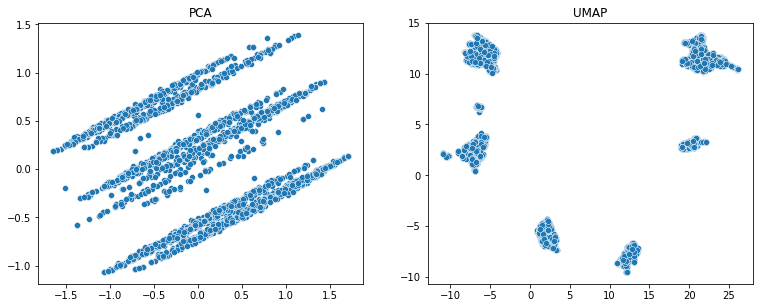

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(depressed_core_df.values)
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

From the visualization you can see clusters.  However because of loss of information, nothing can be inferred.

#### Kmeans clustering

I'm going to use an inertia plot and the Kneed library to help find the elbow to chose te appropriate number of clusters. 

The elbow occurs at 11


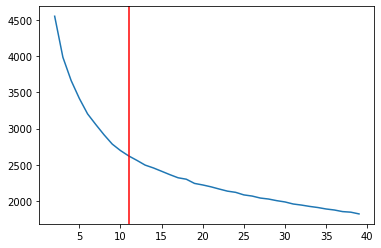

In [18]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

The curve is mostly smooth, it is hard to determine the elbow.  I would guess maybe around 17.  According to kneed, the elbow appears at 11.  I will use 11 for the number of clusters and come up with the silhouette score

In [19]:
kmeans = KMeans(n_clusters=11, random_state=625)
preds = kmeans.fit_predict(X)
score = silhouette_score(X,preds)
silhouette_scores['data set'].append('depression variables')
silhouette_scores['clustering method'].append('kmeans--auto-11')
silhouette_scores['score'].append(score)
print("The silhouette score for 11 clusters is {}".format(score))

The silhouette score for 10 clusters is 0.17040533120852125


The silhouette score is rather low meaning clusters are mixing.  I'm going to try using the full algorithm parameter and see if it improves the silhouette score

In [20]:
kmeans = KMeans(n_clusters=11, algorithm='full', random_state=625)
preds = kmeans.fit_predict(X)
score = silhouette_score(X,preds)
silhouette_scores['data set'].append('depression variables')
silhouette_scores['clustering method'].append('kmeans--full-11')
silhouette_scores['score'].append(score)
print("The silhouette score for 11 clusters is {}".format(score))

The silhouette score for 10 clusters is 0.16677370610640815


This did not improve the score.  

Visualizing the data:

<AxesSubplot:>

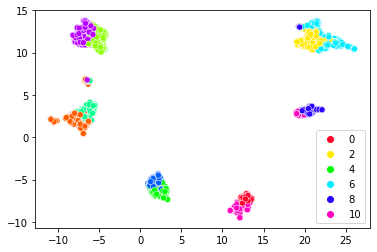

In [21]:
kmeans = KMeans(n_clusters=11, random_state=625)
preds = kmeans.fit_predict(X)
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

Notice that some clusters do appear to be mixing when viewed two dimensionally.

#### DBSCAN

In [22]:
depressed_core_df.shape[1]

12

DBSCAN has two main parameters, eps and min samples. According to the Analytics Vidhya blog post, min samples should be at least one more than the number of parameters<sup>[6](#references)</sup>. Other blogs suggest two times the number of parameters<sup>[7](#references)</sup>. I am going to try values in the range of 13 to 33. I need to find the best epsilon values for these min samples. From the same article, the best epsilon is found using the K_neighbors_graph and looking for the point of maximum curvature. The medium article shows how to plot the k_neighbors graph to determine eps.

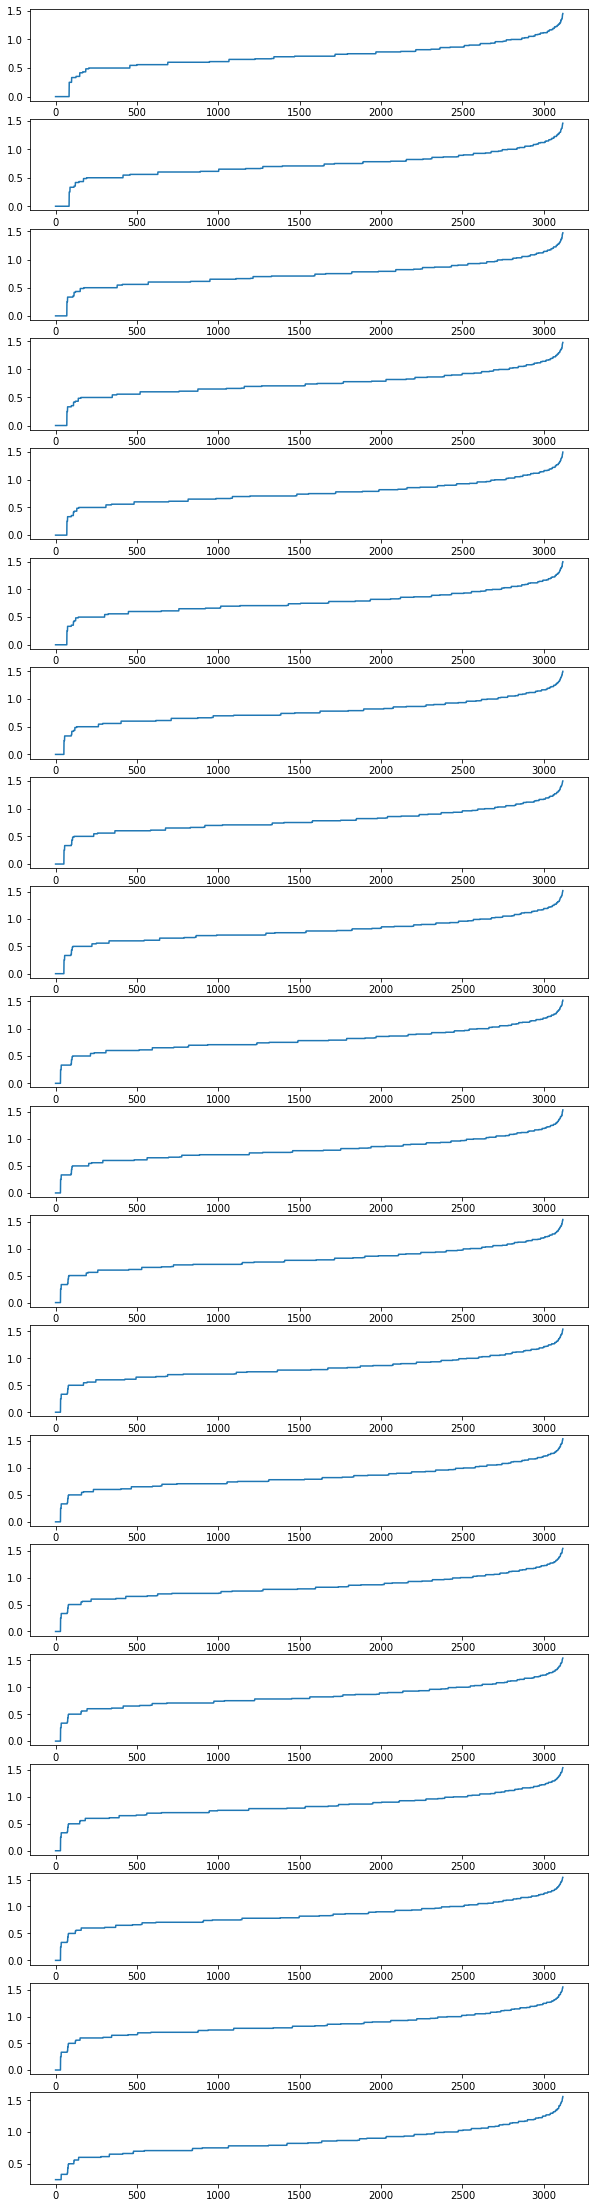

In [23]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(13,33):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k-1]
    axs[i].plot(distances)
    i+=1

For all graphs the point of maximum curvitue looks to be at about y = 1.  I am now going to use silhouette score to find the best min_samples given eps=1.  However there also appears to be a knee at 0.5.  I'm going to try both of these values.  As it is possible to have only outliers or only 1 cluster, a try except block is needed when calculating silhouette score.

In [44]:
max_silhouette = 0
for eps in [0.5,1]:
    for min_samples in range(13,50,1):
        db = DBSCAN(eps=eps, min_samples = min_samples)
        preds = db.fit_predict(X)
        try:
            ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
            if ss > max_silhouette:
                max_silhouette = ss
                best_eps = eps
                best_min_samples = min_samples
        except:
            pass
print("The best eps is {} and the best min_samples is {}".format(best_eps, best_min_samples))

The best eps is 0.5 and the best min_samples is 47


The best min samples is 47 given an epsilon of 0.5.  Finally I will try various epsilons around 0.5 with min samples being 47 to figure out the best eps as I just estimated before with the graph.

In [45]:
max_silhouette = 0
for eps in np.linspace(0.25, 0.75,26):
    db = DBSCAN(eps=eps, min_samples=47)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        if ss > max_silhouette:
            max_silhouette = ss
            best_eps = eps
    except:
        pass

print("The best eps is {}".format(best_eps))

The best eps is 0.51


Finally retraining the data to find the number of clusters, size of clusters, and silhouette score using this min samples and eps.

In [46]:
db = DBSCAN(eps = 0.51, min_samples = 47)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [47]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2956,   98,   64], dtype=int64))

In [48]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.8301550456851392


A large silhouette score was found for those not considered outlier.  However according to the paper, DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN, the amount of noise should be less than 30% and here we have over 90% outliers.  This is not a good set of clusters.  I would choose kmeans with lower silhouette scores over this.

Looking at the visualization in two dimensions

<AxesSubplot:>

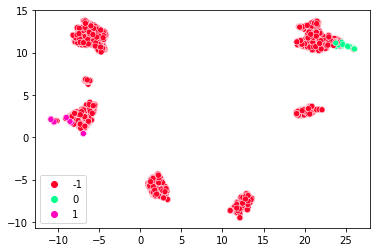

In [49]:
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow')

Most points are outliers.  However it would be an interesting side project to examine the similiarities and differences between the clusters DBSCAN found.

### Clustering depression and demographic variables combined

In [51]:
df_depdemo = pd.concat([depressed_core_df,demo_df],axis=1)
X = scaler.fit_transform(df_depdemo)
df_depdemo.shape[1]

32

#### KMeans

The elbow occurs at 13


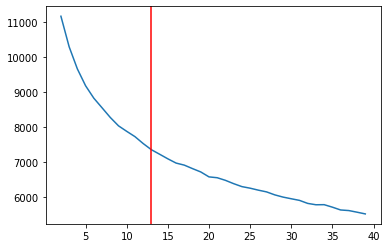

In [52]:
inertia_values = []
for n in range(2,40):
    kmeans = KMeans(n_clusters=n, random_state=625+n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
kl = KneeLocator(x=results[0],y=results[1],direction='decreasing',curve='convex')
elbow = kl.elbow
print('The elbow occurs at',elbow)

sns.lineplot(x=results[0],y=results[1])
plt.axvline(x=elbow, ymin=0, ymax = max(results[1]), color='red')

Kneed found the elbow to be at 13.  Another choice may be 20.  Trying 13 with kmeans

In [53]:
kmeans = KMeans(n_clusters=13, random_state=625)
preds = kmeans.fit_predict(X)
score = silhouette_score(X,preds)
silhouette_scores['data set'].append('depression and demographics')
silhouette_scores['clustering method'].append('kmeans--auto-13')
silhouette_scores['score'].append(score)
print("The silhouette score for 13 clusters is {}".format(score))

The silhouette score for 13 clusters is 0.11342228036785383


The silhouette score is slightly less than that found just using the depression variables.

<a class="anchor" id="results"></a> 
# Results

Now, you can walk through the results of the methods. State the results of your tests and explain whether these results mean that you reject or fail to reject the null. Also include compelling tables or graphs to illustrate your findings.

<a class="anchor" id="discussion"></a> 
# Discussion and Recommendations

What insights can interested parties get from this research? What would you recommend for further research?

<a class="anchor" id="references"></a>   
# References

1. National Institute of Mental Health. Major Depression. https://www.nimh.nih.gov/health/statistics/major-depression

2. InformedHealth.org [Internet]. Cologne, Germany: Institute for Quality and Efficiency in Health Care (IQWiG); 2006-. Depression: How effective are antidepressants? [Updated 2020 Jun 18]. Available from: https://www.ncbi.nlm.nih.gov/books/NBK361016/

3. National Center for Health Statistics. (April 5, 2021) National Health Interview Survey. https://www.cdc.gov/nchs/nhis/2019nhis.htm

4. National Center for Health Statistics. (September 16, 2020). About the National Health Interview Survey. https://www.cdc.gov/nchs/nhis/about_nhis.htm

5. American Psychiatric Association.  (October, 2020). What is depression? https://www.psychiatry.org/patients-families/depression/what-is-depression

6. Sharma, A. (2020, September 8) How to Master the Popular DBSCAN Clustering Algorithm for Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

7. Mullin, T. (2020, July 9) DBSCAN Parameter Estimation Using Python.  Medium. https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

8. Erich Schubert, Jörg Sander, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. 2017. DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN. ACM Trans. Database Syst. 42, 3, Article 19 (July 2017), 21 pages. https://doi.org/10.1145/3068335



<a class="anchor" id="appendix"></a> 
# Appendix

## Exploratory data analysis

### Depression variables

In [24]:
df_depressed_core.head()

,DEPEV_A,DEPFREQ_A,DEPMED_A,DEPLEVEL_A,PHQ81_A,PHQ82_A,PHQ83_A,PHQ84_A,PHQ85_A,PHQ86_A,PHQ87_A,PHQ88_A
4,Yes,Daily,Yes,Somewhere in between,Nearly every day,More than half the days,Several days,More than half the days,Several days,Several days,Nearly every day,Not at all
28,No,Weekly,No,Somewhere in between,Not at all,More than half the days,More than half the days,Not at all,Several days,More than half the days,Not at all,Not at all
37,Yes,Daily,Yes,Somewhere in between,Not at all,More than half the days,Nearly every day,Several days,Not at all,Several days,Not at all,Not at all
41,No,Weekly,No,Somewhere in between,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,Nearly every day,Nearly every day,Not at all
48,Yes,Daily,No,A little,Not at all,Several days,Not at all,Not at all,Several days,Not at all,Nearly every day,Not at all


#### DEPEV_A

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?"

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

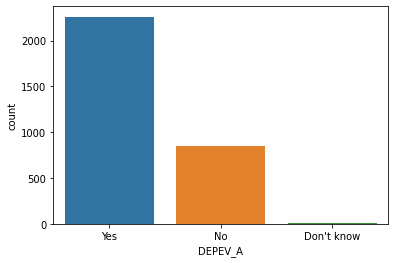

In [25]:
sns.countplot(x='DEPEV_A',data=df_depressed_core)

The majority that feel depression on a weekly or daily basis have been told by a doctor they do have depression.

#### DEPFREQ_A

DEPFREQ_A is the response to the question, "how often do you feel depressed?"

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

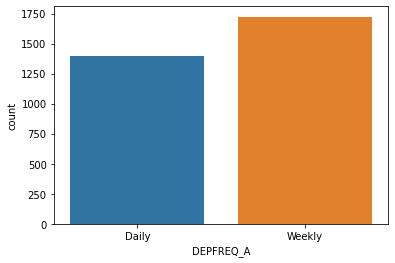

In [26]:
sns.countplot(x='DEPFREQ_A', data=df_depressed_core)

As seen above, a little more than half of the people feel depressed on a weekly basis.

#### DEPMED_A

DEPMED_A represents responces to the question, "Do you take prescription medication for depression?"



<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

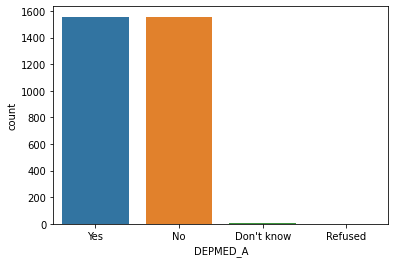

In [27]:
sns.countplot(x='DEPMED_A',data=df_depressed_core)

Approximately half of the respondents do take medication.  It would be intererested to explore the relationship between levels of depression and DEPMED_A as well as exploring medical insurance variables for those whom do not take medication. 

#### DEPLEVEL_A

DEPLEVEL_A is the respondent's answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?"

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

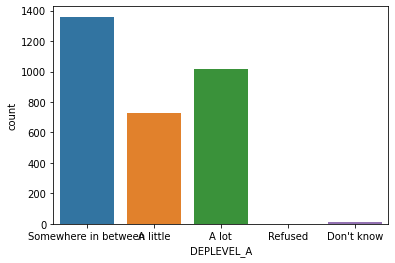

In [28]:
sns.countplot(x='DEPLEVEL_A', data=df_depressed_core)

Most people feeling depressed on a daily or weekly basis said they feel somewhere in between a little and a lot depressed.

#### PHQ81_A through PHQ88_A

These questions ask how often they are bothered by certain symptoms of depression within the last two weeks.

Text(0.5, 1.0, 'Moving or speaking slow or fast')

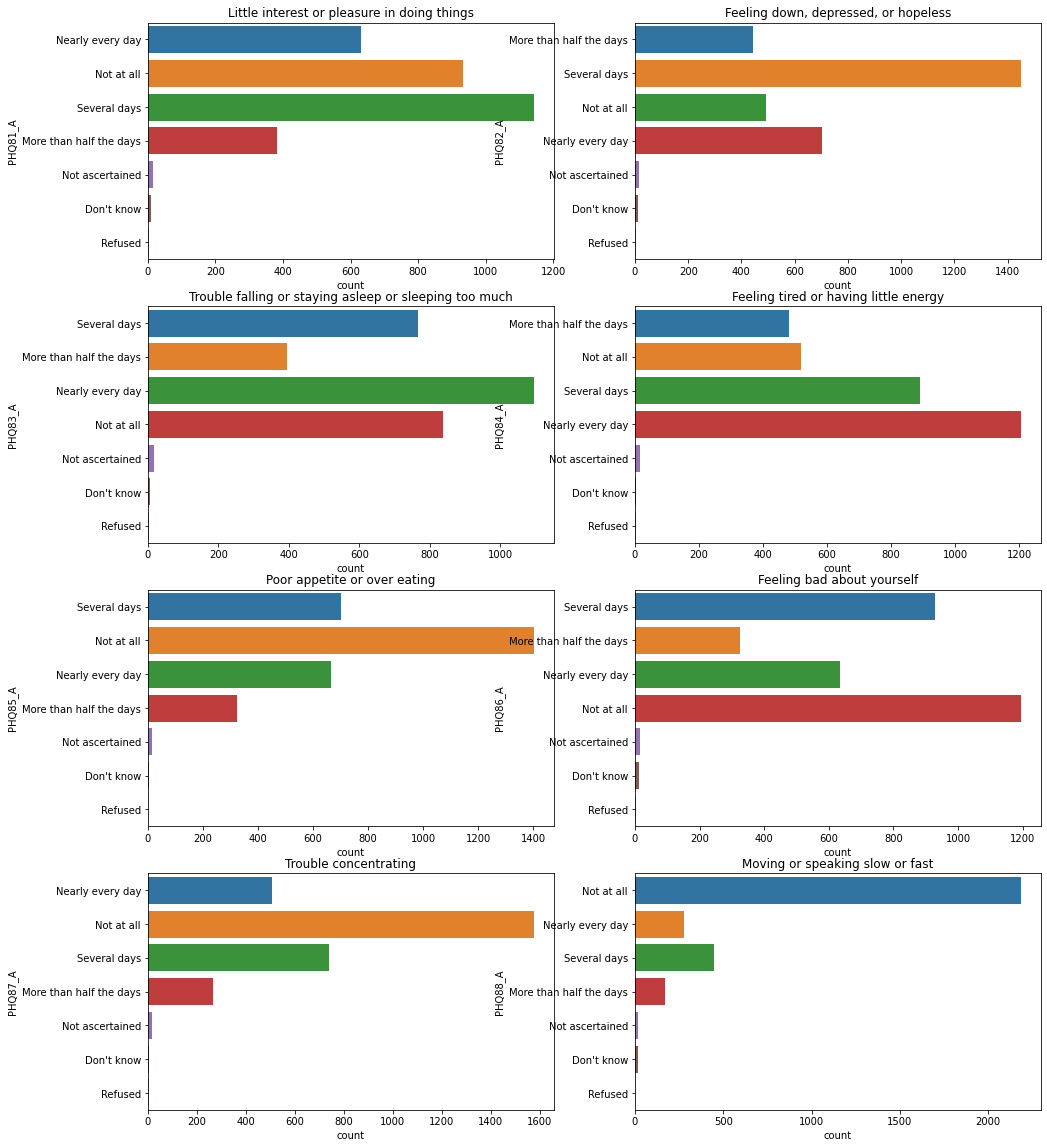

In [29]:
fig, axs = plt.subplots(4,2, figsize=(16,20))
sns.countplot(y='PHQ81_A',data=df_depressed_core,ax=axs[0,0])
axs[0,0].set_title('Little interest or pleasure in doing things')
sns.countplot(y='PHQ82_A',data=df_depressed_core,ax=axs[0,1])
axs[0,1].set_title('Feeling down, depressed, or hopeless')
sns.countplot(y='PHQ83_A',data=df_depressed_core,ax=axs[1,0])
axs[1,0].set_title('Trouble falling or staying asleep or sleeping too much')
sns.countplot(y='PHQ84_A',data=df_depressed_core,ax=axs[1,1])
axs[1,1].set_title('Feeling tired or having little energy')
sns.countplot(y='PHQ85_A',data=df_depressed_core,ax=axs[2,0])
axs[2,0].set_title('Poor appetite or over eating')
sns.countplot(y='PHQ86_A',data=df_depressed_core,ax=axs[2,1])
axs[2,1].set_title('Feeling bad about yourself')
sns.countplot(y='PHQ87_A',data=df_depressed_core,ax=axs[3,0])
axs[3,0].set_title('Trouble concentrating')
sns.countplot(y='PHQ88_A',data=df_depressed_core,ax=axs[3,1])
axs[3,1].set_title('Moving or speaking slow or fast')


As you can see the most common frequency of the symptoms vary from not at all to nearly every day.

### Demographic information

In [30]:
df_demo.head()

,AGEP_A,SEX_A,MARITAL_A,FAMINCTC_A,EDUC_A,EMPWRKLSWK_A,RACEALLP_A,HISP_A
4,60,Male,Married,30000,"Some college, no degree",Yes,White only,No
28,26,Male,Married,60000,Grade 8 - 11,No,Black/African American only,No
37,60,Female,Neither,52877,"Some college, no degree",No,White only,No
41,24,Female,"Unmarried, living with partner",20000,"Some college, no degree",Yes,American indian and other,No
48,53,Female,Neither,9000,"Some college, no degree",No,White only,Yes


#### AGEP_A 
AGEP_A holds the age of the adult.

<AxesSubplot:>

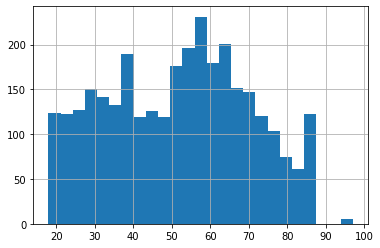

In [31]:
df_demo.AGEP_A.hist(bins=25)

All age groups are represented with some peaks around or before 40, between 50 and 60, and around 85.  Those between 50 and 60 may be depressed because they are facing a mid life crisis.  For women, maybe menapause cases depression?

#### SEX_A
SEX_A states the sex of the adult



<AxesSubplot:xlabel='SEX_A', ylabel='count'>

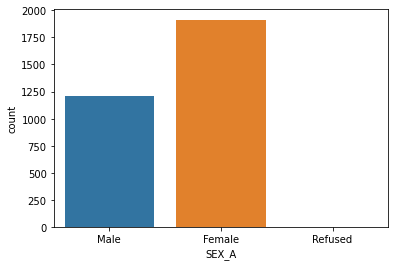

In [32]:
sns.countplot(x='SEX_A', data=df_demo)

More women feel depressed on a weekly or daily basis then men.

#### MARITAL_A
MARITAL_A states the marital status

<AxesSubplot:xlabel='count', ylabel='MARITAL_A'>

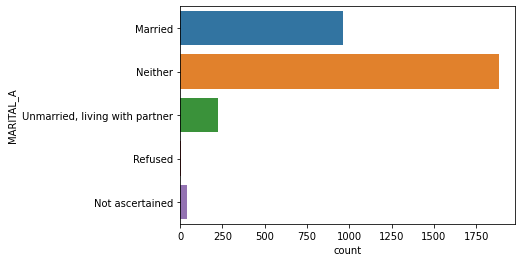

In [33]:
sns.countplot(y='MARITAL_A',data=df_demo)

The majority of those that feel depressed on a daily or weekly basis are neither married no living with a partner.

#### FAMINCTC_A
FAMINCTC_A lists the family income of the individual

<AxesSubplot:>

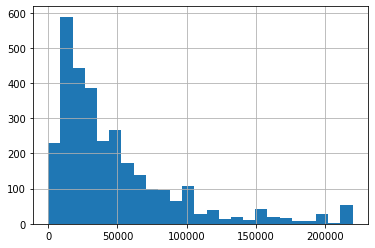

In [34]:
df_demo.FAMINCTC_A.hist(bins=25)

As can be seen, the majority of those that feel depressed on a daily or weekly basis appear to have a family income of less than 50k.

#### EDUC_A
EDUC_A lists the education level of the individual.

<AxesSubplot:xlabel='count', ylabel='EDUC_A'>

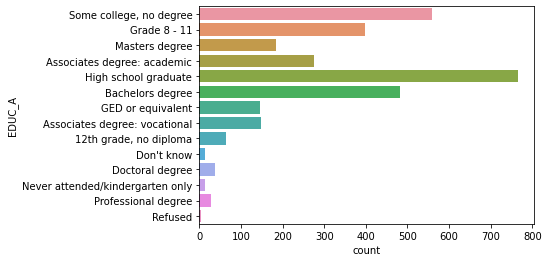

In [35]:
sns.countplot(y='EDUC_A',data=df_demo)

The majprity of those that feel depressed on a daily or weekly basis are high school graduates.
There are many levels with very few counts.  When preparing data I may want to combine some such as the associates degrees and the professional and masters degrees.


#### EMPWRKLSWK_A
EMPWRKLSWK_A denotes if the individual worked last week.

<AxesSubplot:xlabel='EMPWRKLSWK_A', ylabel='count'>

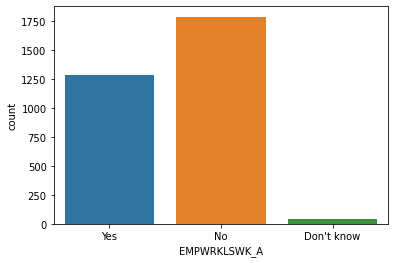

In [36]:
sns.countplot(x='EMPWRKLSWK_A',data=df_demo)

The majority of those whom fell depressed dd not work.  This poses the question did the depression stop them from working or are they depressed due to unemployment?

#### RACEALLP_A

RACEALLP_A covers the race of the adult


<AxesSubplot:xlabel='count', ylabel='RACEALLP_A'>

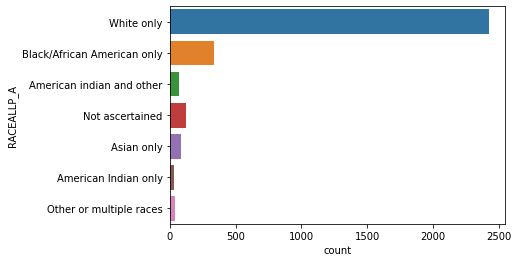

In [37]:
sns.countplot(y='RACEALLP_A', data=df_demo)

The majority are white only, however the majority of respondents were white.

Because there are so very few of other races, I will want to combine some when preparing the data.  Looking at percent amounts

In [38]:
df_demo.RACEALLP_A.value_counts()/df_demo.shape[0]

White only                     0.777101
Black/African American only    0.107761
Not ascertained                0.040411
Asian only                     0.026940
American indian and other      0.022771
Other or multiple races        0.013791
American Indian only           0.011225
Name: RACEALLP_A, dtype: float64

I will keep white and black/african american but combine everything else into an other.

#### HISP_A
HISP_A states wether or not the adult is of Hispanic ethnicity.

<AxesSubplot:xlabel='HISP_A', ylabel='count'>

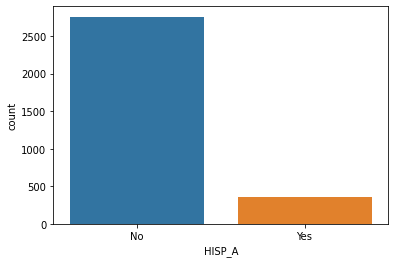

In [39]:
sns.countplot(x='HISP_A',data=df_demo)

The majority are not of Hispanic ethnicity, but then again the majority of the respondants were not Hispanic.

### Chronic conditions

The variables address the following questions

* HYPEV_A -- Have you ever been told you have hypertension?
* CHLEV_A -- Have you ever been told you have high cholesterol?
* ASEV_A -- Have you ever been told you have asthma?
* CANEV_A -- Have you ever been told you have cancer?
* DIBEV_A -- Have you ever been told you have diabetes?
* COPDEV_A -- Have you ever been told you have COPD, chronic bronchitis or emphysema?

<AxesSubplot:xlabel='COPDEV_A', ylabel='count'>

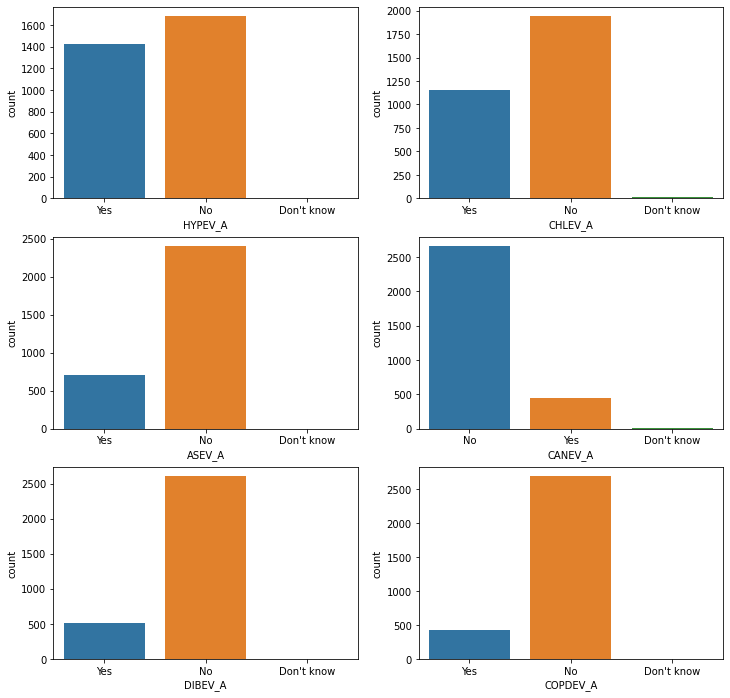

In [40]:
fig, axs = plt.subplots(3,2, figsize = (12,12))
sns.countplot(x='HYPEV_A', data = df_cc, ax=axs[0,0])
sns.countplot(x='CHLEV_A', data = df_cc, ax=axs[0,1])
sns.countplot(x='ASEV_A', data = df_cc, ax=axs[1,0])
sns.countplot(x='CANEV_A', data = df_cc, ax=axs[1,1])
sns.countplot(x='DIBEV_A', data = df_cc, ax=axs[2,0])
sns.countplot(x='COPDEV_A', data = df_cc, ax=axs[2,1])

Most of those whom feel depressed on a daily or weekly basis do not have chronic conditions. The numbers are close for those with hypertension.  About 1/3 of those with high cholesterol feel depressed.

## Why not one-hot encode the depression variables?

With clustering you are interested in distances, or differences.  When given values that have a natural order you do not want to one hot encode them.  For example, say everything else was held constant except for how often a person feels fatigued.  Looking at three observations, one person feels fatigued nearly every day, another person feels fatigue not at all, and another person feels fatigued several days.  If fatigue frequency was one hot encoded, then the distance between the person the feels fatigued every day and the person feeling fatigued several days will be the same as the distance between the person that feels fatigued every day and the person that does not feel fatigued at all if using Euclidean or Manhattan distance.  When in fact the latter is much more different than the former.

## Links

Anne Losch on LinkedIn. https://www.linkedin.com/in/annelosch/
